In [3]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
mongo = MongoClient(port=27017)

In [4]:
# Load data from Excel
file_path = '/Users/janelu/Desktop/project/Core_CPI_not seas_adj.xlsx'
monthly_data = pd.read_excel(file_path, sheet_name='monthly')

# Remove entirely empty rows and create a clean copy
monthly_data_cleaned = monthly_data.dropna(how='all').copy()

# Rename the 'Date' column
monthly_data_cleaned.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

# Convert 'Date' column to datetime format
monthly_data_cleaned['Date'] = pd.to_datetime(
    monthly_data_cleaned['Date'].str.replace('M', '-').astype(str),
    format='%Y-%m'
)


In [5]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["cpi_database"]
collection = db["cpi_data"]

# Prepare data for insertion
records = []
for _, row in monthly_data_cleaned.iterrows():
    for country in ["Brazil", "Canada", "United States"]:  # Specify countries of interest
        if pd.notna(row[country]):
            records.append({
                "date": row["Date"],
                "country": country,
                "cpi": row[country]
            })

# Insert data into MongoDB
collection.insert_many(records)


InsertManyResult([ObjectId('675a3d47def1da63a8f3f30d'), ObjectId('675a3d47def1da63a8f3f30e'), ObjectId('675a3d47def1da63a8f3f30f'), ObjectId('675a3d47def1da63a8f3f310'), ObjectId('675a3d47def1da63a8f3f311'), ObjectId('675a3d47def1da63a8f3f312'), ObjectId('675a3d47def1da63a8f3f313'), ObjectId('675a3d47def1da63a8f3f314'), ObjectId('675a3d47def1da63a8f3f315'), ObjectId('675a3d47def1da63a8f3f316'), ObjectId('675a3d47def1da63a8f3f317'), ObjectId('675a3d47def1da63a8f3f318'), ObjectId('675a3d47def1da63a8f3f319'), ObjectId('675a3d47def1da63a8f3f31a'), ObjectId('675a3d47def1da63a8f3f31b'), ObjectId('675a3d47def1da63a8f3f31c'), ObjectId('675a3d47def1da63a8f3f31d'), ObjectId('675a3d47def1da63a8f3f31e'), ObjectId('675a3d47def1da63a8f3f31f'), ObjectId('675a3d47def1da63a8f3f320'), ObjectId('675a3d47def1da63a8f3f321'), ObjectId('675a3d47def1da63a8f3f322'), ObjectId('675a3d47def1da63a8f3f323'), ObjectId('675a3d47def1da63a8f3f324'), ObjectId('675a3d47def1da63a8f3f325'), ObjectId('675a3d47def1da63a8f3f3

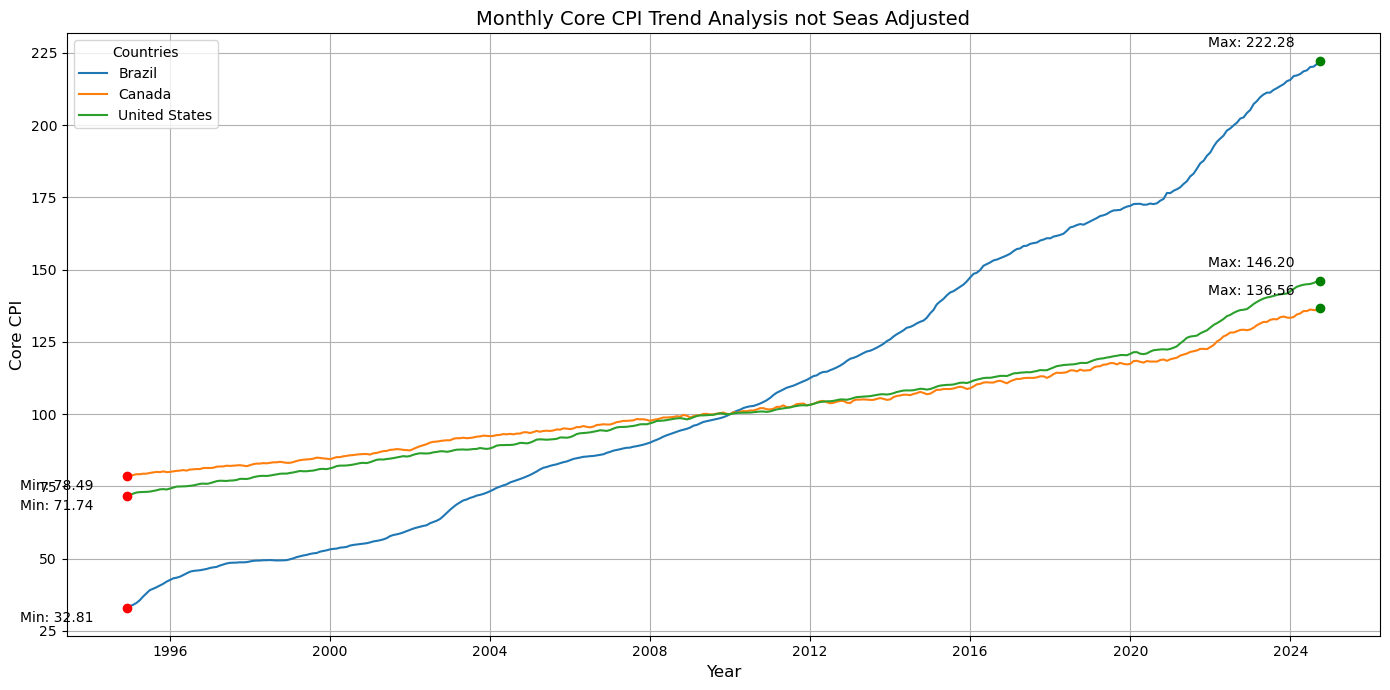

In [6]:
# Exclude the '_id' field when querying from MongoDB
query_results = collection.find({"country": {"$in": ["Brazil", "Canada", "United States"]}}, {"_id": 0})

# Load query results into a Pandas DataFrame
trend_data = pd.DataFrame(list(query_results))

# Ensure 'date' is in datetime format
trend_data["date"] = pd.to_datetime(trend_data["date"])

# Remove duplicates by keeping the first occurrence
trend_data = trend_data.drop_duplicates(subset=["date", "country"])

# OR: Aggregate duplicates by averaging (if duplicates are valid)
trend_data = trend_data.groupby(["date", "country"], as_index=False).mean()

# Pivot data for easier visualization
trend_data_pivot = trend_data.pivot(index="date", columns="country", values="cpi")

# Plot the trends
plt.figure(figsize=(14, 7))
for country in trend_data_pivot.columns:
    country_data = trend_data_pivot[country]
    
    # Plot the trend line
    plt.plot(trend_data_pivot.index, country_data, label=country)
    
    # Find the lowest and highest points
    min_point_date = country_data.idxmin()
    min_point_value = country_data.min()
    max_point_date = country_data.idxmax()
    max_point_value = country_data.max()
    
    # Highlight the lowest point
    plt.scatter(min_point_date, min_point_value, color='red', zorder=5)
    plt.annotate(f"Min: {min_point_value:.2f}", 
                 (min_point_date, min_point_value),
                 textcoords="offset points", xytext=(-50, -10), ha='center')
    
    # Highlight the highest point
    plt.scatter(max_point_date, max_point_value, color='green', zorder=5)
    plt.annotate(f"Max: {max_point_value:.2f}", 
                 (max_point_date, max_point_value),
                 textcoords="offset points", xytext=(-50, 10), ha='center')

# Customize the plot
plt.title("Monthly Core CPI Trend Analysis not Seas Adjusted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Core CPI", fontsize=12)
plt.legend(title="Countries", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


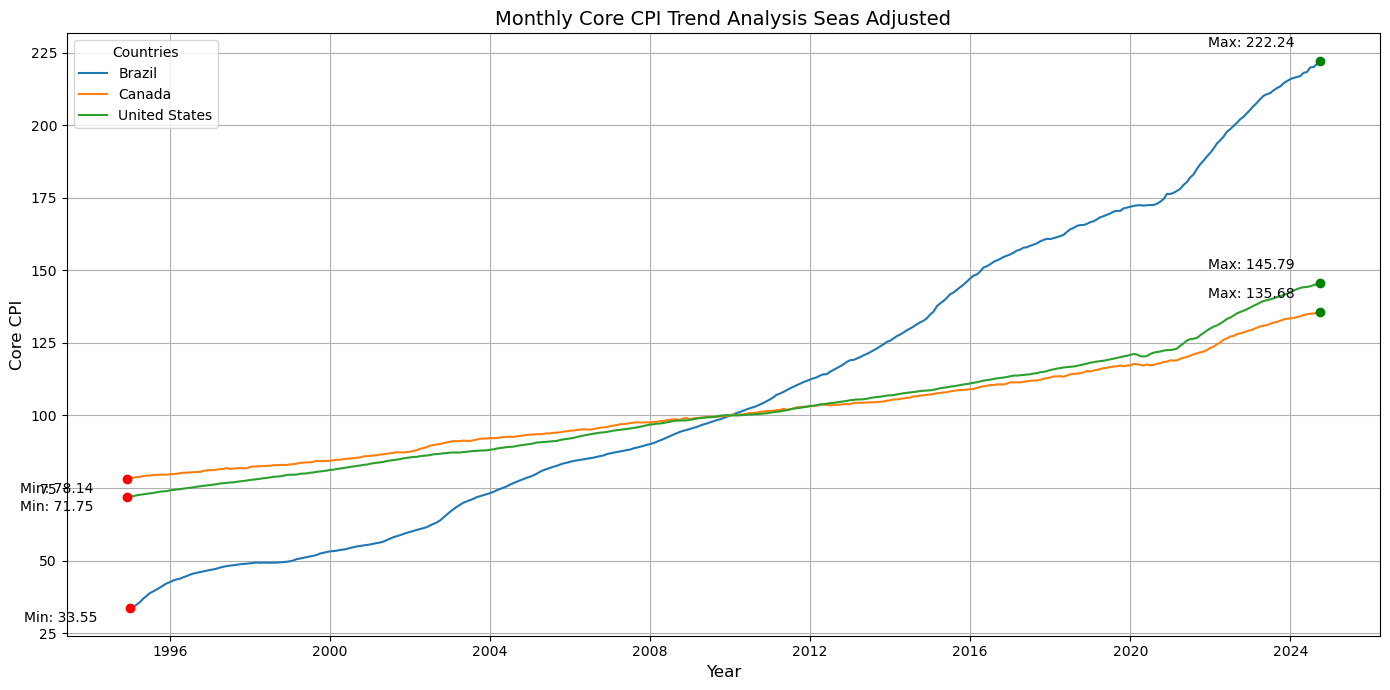

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Use the uploaded file path
file_path = '/Users/janelu/Desktop/project/Core_CPI_seas_adj.xlsx'

# Load the Excel file
monthly_data = pd.read_excel(file_path, sheet_name='monthly')

# Remove entirely empty rows and create a clean copy
monthly_data_cleaned = monthly_data.dropna(how='all').copy()

# Rename the 'Date' column
monthly_data_cleaned.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

# Convert 'Date' column to datetime format
monthly_data_cleaned['Date'] = pd.to_datetime(
    monthly_data_cleaned['Date'].str.replace('M', '-').astype(str),
    format='%Y-%m'
)

# Filter data for specific countries of interest
countries_of_interest = ["Brazil", "Canada", "United States"]
filtered_data = monthly_data_cleaned[["Date"] + countries_of_interest].dropna(how='all')

# Reshape the data for easier plotting
trend_data = filtered_data.melt(id_vars="Date", 
                                value_vars=countries_of_interest, 
                                var_name="Country", 
                                value_name="CPI")

# Plot the trends
plt.figure(figsize=(14, 7))
for country in countries_of_interest:
    country_data = trend_data[trend_data["Country"] == country]
    
    # Plot the trend line
    plt.plot(country_data["Date"], country_data["CPI"], label=country)
    
    # Find the lowest and highest points
    min_point = country_data.loc[country_data["CPI"].idxmin()]
    max_point = country_data.loc[country_data["CPI"].idxmax()]
    
    # Highlight the lowest point
    plt.scatter(min_point["Date"], min_point["CPI"], color='red', zorder=5)
    plt.annotate(f"Min: {min_point['CPI']:.2f}", 
                 (min_point["Date"], min_point["CPI"]),
                 textcoords="offset points", xytext=(-50, -10), ha='center')
    
    # Highlight the highest point
    plt.scatter(max_point["Date"], max_point["CPI"], color='green', zorder=5)
    plt.annotate(f"Max: {max_point['CPI']:.2f}", 
                 (max_point["Date"], max_point["CPI"]),
                 textcoords="offset points", xytext=(-50, 10), ha='center')

# Customize the plot
plt.title("Monthly Core CPI Trend Analysis Seas Adjusted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Core CPI", fontsize=12)
plt.legend(title="Countries", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


Starting data loading process...
Loaded CSV file with shape: (361, 13)
Created 361 records for MongoDB

Starting plot creation...

Retrieved data from MongoDB with shape: (361, 15)

After date processing, DataFrame shape: (360, 14)
Plotting Advanced Economies with 359 points
Plotting EMDE East Asia & Pacific with 359 points
Plotting EMDE Europe & Central Asia with 359 points
Plotting EMDE South Asia with 359 points
Plotting EMDE Latin America & Caribbean with 359 points


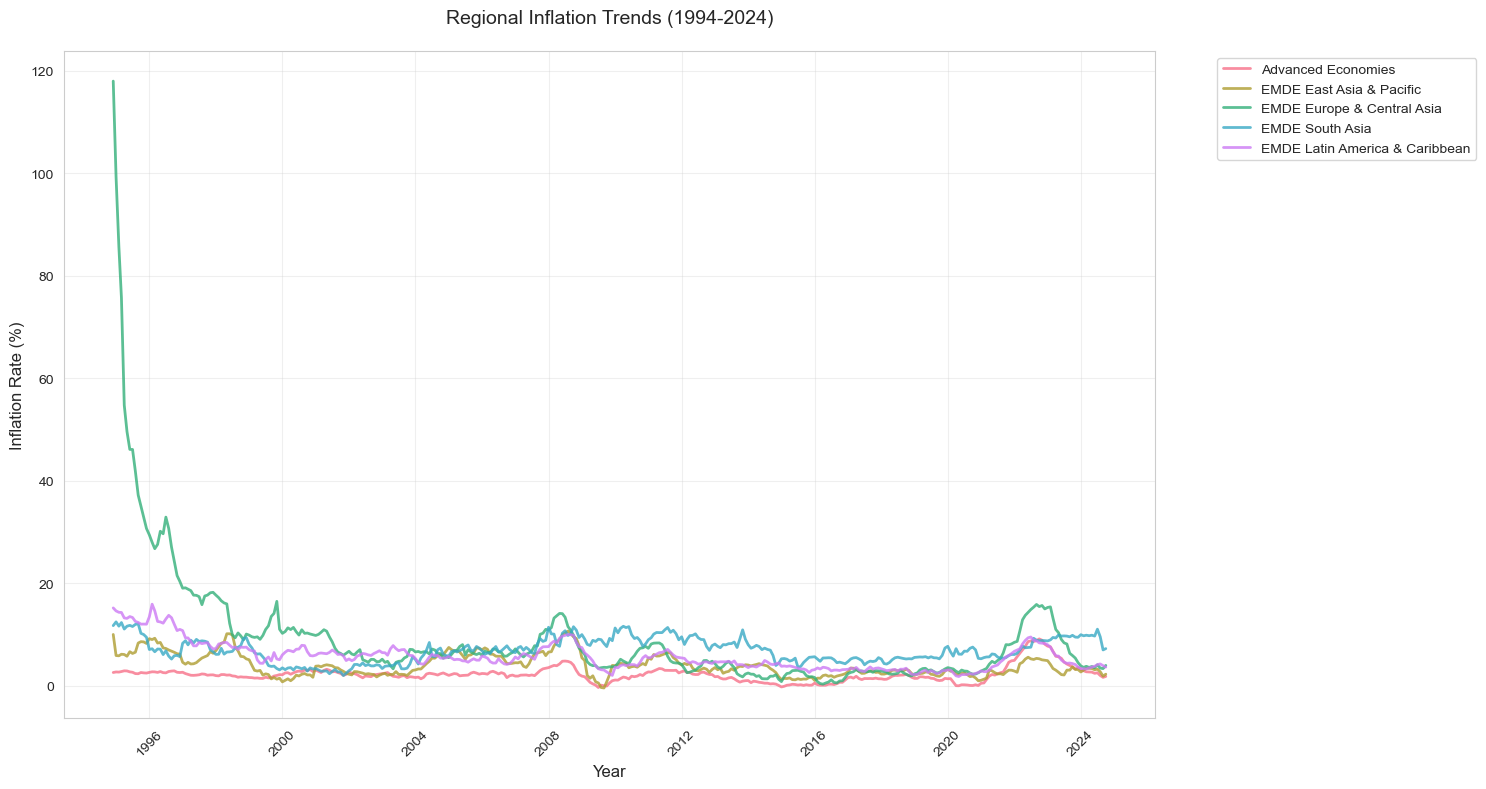

In [20]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns

# MongoDB connection
mongo = MongoClient(port=27017)

# File path
file_path = '/Users/janelu/Desktop/project/CPI_Price_median.csv'

def load_data_to_mongodb(file_path, mongo_client):
    # Read CSV file
    df = pd.read_csv(file_path)
    print(f"Loaded CSV file with shape: {df.shape}")
    
    # Create database and collection
    db = mongo_client.inflation_db
    collection = db.regional_inflation
    
    # Drop existing collection if it exists
    collection.drop()
    
    # Convert DataFrame to records for MongoDB
    records = []
    for index, row in df.iterrows():
        record = row.to_dict()
        record['date'] = row['Unnamed: 0']
        records.append(record)
    
    print(f"Created {len(records)} records for MongoDB")
    
    # Insert records
    if records:
        collection.insert_many(records)
    return db

def plot_inflation_trends_from_mongo(mongo_client):
    # Get data from MongoDB
    db = mongo_client.inflation_db
    cursor = db.regional_inflation.find({})
    
    # Convert to DataFrame
    df = pd.DataFrame(list(cursor))
    print(f"\nRetrieved data from MongoDB with shape: {df.shape}")
    
    # Handle date conversion
    def convert_date(date_str):
        try:
            if pd.isna(date_str):
                return None
            # Split by 'M' and handle the parts
            year, month = date_str.split('M')
            # Ensure month is two digits
            month = month.zfill(2)
            return pd.to_datetime(f"{year}-{month}-01")
        except Exception as e:
            print(f"Error parsing date {date_str}: {e}")
            return None
    
    # Convert dates
    df['date'] = df['date'].apply(convert_date)
    df = df.dropna(subset=['date'])
    df.set_index('date', inplace=True)
    
    print(f"\nAfter date processing, DataFrame shape: {df.shape}")
    
    # Remove MongoDB _id column and unnamed column
    df = df.drop(['_id', 'Unnamed: 0'], axis=1)
    
    # Sort index
    df = df.sort_index()
    
    # Select key regions for clarity
    regions_to_plot = [
        'Advanced Economies',
        'EMDE East Asia & Pacific',
        'EMDE Europe & Central Asia',
        'EMDE South Asia',
        'EMDE Latin America & Caribbean'
    ]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot each region with different colors
    colors = sns.color_palette("husl", len(regions_to_plot))
    for region, color in zip(regions_to_plot, colors):
        if region in df.columns:
            data = df[region].dropna().astype(float)
            ax.plot(data.index, data.values, label=region, linewidth=2, alpha=0.8, color=color)
            print(f"Plotting {region} with {len(data)} points")
    
    # Customize the plot
    ax.set_title('Regional Inflation Trends (1994-2024)', fontsize=14, pad=20)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Inflation Rate (%)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Customize legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

print("Starting data loading process...")
# Load data into MongoDB
load_data_to_mongodb(file_path, mongo)

print("\nStarting plot creation...")
# Create and display the plot
plt = plot_inflation_trends_from_mongo(mongo)
plt.show()

Loaded CSV file with shape: (31, 122)
Created 31 records for MongoDB
Plotting Advanced Economies with 30 points
Plotting EMDE East Asia & Pacific with 30 points
Plotting EMDE Europe & Central Asia with 30 points
Plotting EMDE South Asia with 24 points
Plotting EMDE Latin America & Caribbean with 30 points


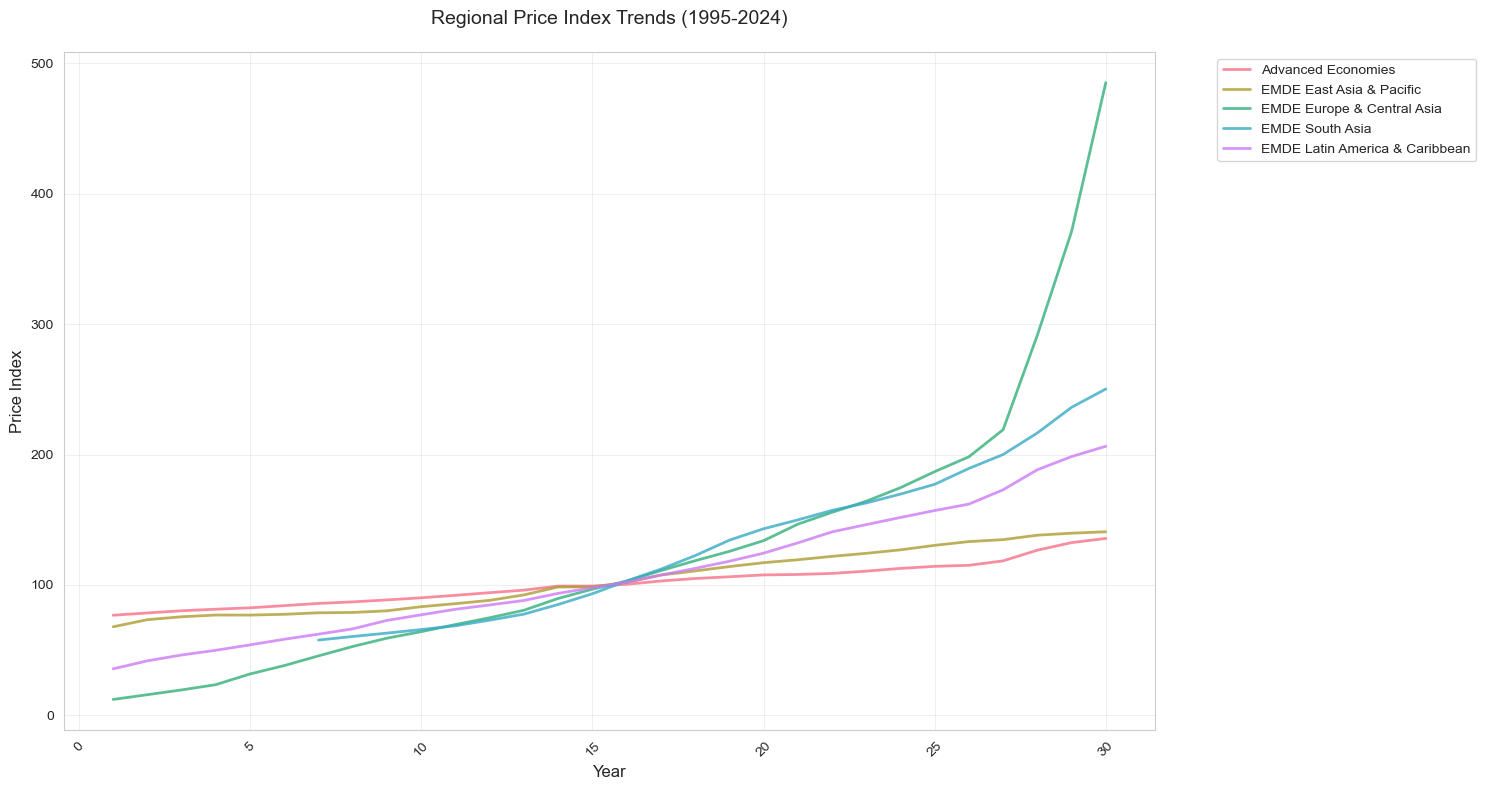

In [21]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns

# MongoDB connection
mongo = MongoClient(port=27017)

# File path
file_path = '/Users/janelu/Desktop/project/CPI_Price_nominal.csv'

def load_data_to_mongodb(file_path, mongo_client):
    # Read CSV file
    df = pd.read_csv(file_path)
    print(f"Loaded CSV file with shape: {df.shape}")
    
    # Create database and collection
    db = mongo_client.price_db
    collection = db.price_index
    
    # Drop existing collection if it exists
    collection.drop()
    
    # Convert DataFrame to records for MongoDB
    records = []
    for index, row in df.iterrows():
        record = row.to_dict()
        record['year'] = index
        records.append(record)
    
    print(f"Created {len(records)} records for MongoDB")
    
    # Insert records
    if records:
        collection.insert_many(records)
    return db

def plot_price_trends_from_mongo(mongo_client):
    # Get data from MongoDB
    db = mongo_client.price_db
    cursor = db.price_index.find({})
    
    # Convert to DataFrame
    df = pd.DataFrame(list(cursor))
    
    # Set index
    df.set_index('year', inplace=True)
    
    # Remove MongoDB _id column
    df = df.drop('_id', axis=1)
    
    # Select key regions for clarity
    regions_to_plot = [
        'Advanced Economies',
        'EMDE East Asia & Pacific',
        'EMDE Europe & Central Asia',
        'EMDE South Asia',
        'EMDE Latin America & Caribbean'
    ]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot each region with different colors
    colors = sns.color_palette("husl", len(regions_to_plot))
    for region, color in zip(regions_to_plot, colors):
        if region in df.columns:
            data = df[region].dropna().astype(float)
            ax.plot(data.index, data.values, label=region, linewidth=2, alpha=0.8, color=color)
            print(f"Plotting {region} with {len(data)} points")
    
    # Customize the plot
    ax.set_title('Regional Price Index Trends (1995-2024)', fontsize=14, pad=20)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Price Index', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Customize legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

# Load data into MongoDB and create visualization
load_data_to_mongodb(file_path, mongo)
plt = plot_price_trends_from_mongo(mongo)
plt.show()